In [43]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold, SelectFromModel, RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc, roc_auc_score
from tqdm import tqdm
import shap
import optuna
import optuna.logging
import warnings
import multiprocessing
import json
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppress Optuna output

# Set seed for reproducibility
np.random.seed(42)

# Set visualization style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [44]:
# Load UCI Heart Disease Cleveland dataset only
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, names=columns, na_values='?')

# Display shape and head
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [45]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [47]:
# Handle missing values
print('Missing values before imputation:\n', df.isnull().sum())

numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

for col in numerical_features:
    df[col].fillna(df[col].median(), inplace=True)

for col in categorical_features:
    df[col].fillna(df[col].mode()[0], inplace=True)

print('Missing values after imputation:\n', df.isnull().sum())

Missing values before imputation:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64
Missing values after imputation:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


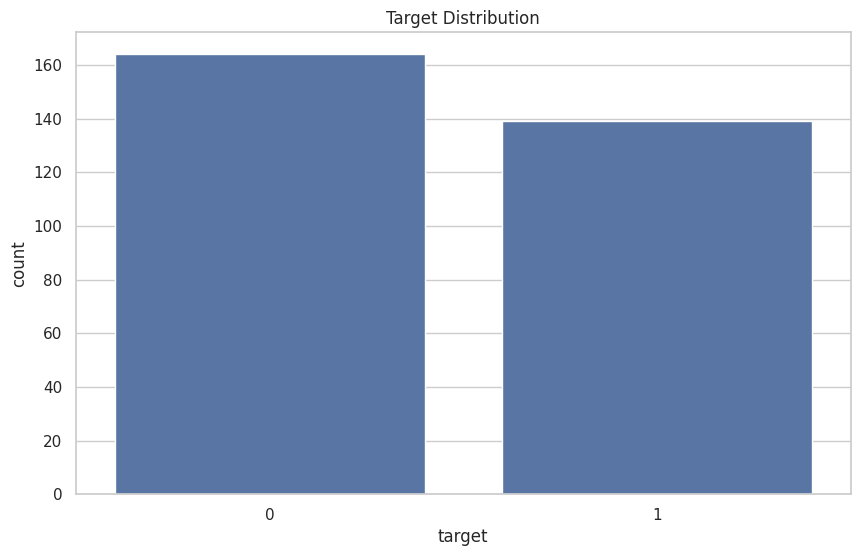

target
0    0.541254
1    0.458746
Name: proportion, dtype: float64


In [48]:
# Binarize target and visualize
df['target'] = np.where(df['num'] > 0, 1, 0)
df.drop('num', axis=1, inplace=True)

sns.countplot(x='target', data=df)
plt.title('Target Distribution')
plt.show()

print(df['target'].value_counts(normalize=True))

In [49]:
# Feature Engineering Options
def fe_basic(df):
    return df.copy(), numerical_features.copy(), categorical_features.copy()

def fe_enhanced(df):
    df = df.copy()
    # Binning
    df['age_bin'] = pd.cut(df['age'], bins=[0, 40, 50, 60, 70, 100], labels=[0,1,2,3,4]).astype(float)
    df['chol_bin'] = pd.cut(df['chol'], bins=[0, 200, 240, 300, 1000], labels=[0,1,2,3]).astype(float)
    df['trestbps_bin'] = pd.cut(df['trestbps'], bins=[0, 120, 140, 160, 200], labels=[0,1,2,3]).astype(float)
    
    cat = categorical_features + ['age_bin', 'chol_bin', 'trestbps_bin']
    
    # Interactions
    df['age_chol'] = df['age'] * df['chol']
    df['oldpeak_slope'] = df['oldpeak'] * df['slope']
    df['thalach_exang'] = df['thalach'] * df['exang']
    df['cp_oldpeak'] = df['cp'] * df['oldpeak']
    
    num = numerical_features + ['age_chol', 'oldpeak_slope', 'thalach_exang', 'cp_oldpeak']
    
    # Polynomial features
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    poly_df = pd.DataFrame(poly.fit_transform(df[num]), columns=poly.get_feature_names_out(num), index=df.index)
    df = pd.concat([df.drop(num, axis=1), poly_df], axis=1)
    num = list(poly.get_feature_names_out(num))
    
    # Transformations
    pt = PowerTransformer(method='yeo-johnson')
    df[num] = pt.fit_transform(df[num])
    
    return df, num, cat

def fe_poly_only(df):
    df = df.copy()
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_df = pd.DataFrame(poly.fit_transform(df[numerical_features]), columns=poly.get_feature_names_out(numerical_features), index=df.index)
    df = pd.concat([df.drop(numerical_features, axis=1), poly_df], axis=1)
    num = list(poly.get_feature_names_out(numerical_features))
    return df, num, categorical_features

fe_options = {
    'basic': fe_basic,
    'enhanced': fe_enhanced,
    'poly_only': fe_poly_only
}

In [50]:
# Scaler Options
scaler_options = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler()
}

In [51]:
# Feature Selection Options
def fs_variance(X_pre, y, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X_pre)
    return X_pre[:, selector.get_support()], np.where(selector.get_support())[0]

def fs_correlation(X_pre, y, corr_threshold=0.9):
    df_pre = pd.DataFrame(X_pre)
    df_pre.columns = df_pre.columns.astype(str)
    corr = df_pre.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    keep = [i for i in range(X_pre.shape[1]) if i not in to_drop]
    return X_pre[:, keep], np.array(keep)

def fs_kbest_f(X_pre, y, k=0.8):
    if isinstance(k, float):
        k = int(X_pre.shape[1] * k)
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X_pre, y)
    return X_pre[:, selector.get_support()], np.where(selector.get_support())[0]

def fs_kbest_mi(X_pre, y, k=0.8):
    if isinstance(k, float):
        k = int(X_pre.shape[1] * k)
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_pre, y)
    return X_pre[:, selector.get_support()], np.where(selector.get_support())[0]

def fs_rfe_svm(X_pre, y):
    model = SVC(kernel='linear', random_state=42)
    selector = RFE(model, n_features_to_select=int(X_pre.shape[1] * 0.8), step=0.2)
    selector.fit(X_pre, y)
    return X_pre[:, selector.get_support()], np.where(selector.get_support())[0]

def fs_select_model_lr(X_pre, y):
    model = LogisticRegression(random_state=42, max_iter=500)
    selector = SelectFromModel(model, threshold='median')
    selector.fit(X_pre, y)
    return X_pre[:, selector.get_support()], np.where(selector.get_support())[0]

def fs_rfe_lr(X_pre, y):
    model = LogisticRegression(random_state=42, max_iter=500)
    selector = RFE(model, n_features_to_select=int(X_pre.shape[1] * 0.8), step=0.2)
    selector.fit(X_pre, y)
    return X_pre[:, selector.get_support()], np.where(selector.get_support())[0]

def fs_boruta(X_pre, y, max_iter=50, alpha=0.05):
    X = pd.DataFrame(X_pre)
    X.columns = X.columns.astype(str)
    num_feat = X.shape[1]
    hits = np.zeros(num_feat)
    for iter_ in range(max_iter):
        shadow = X.apply(np.random.permutation)
        shadow.columns = [f'shadow_{i}' for i in range(num_feat)]
        X_boruta = pd.concat([X, shadow], axis=1)
        rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=42)
        rf.fit(X_boruta, y)
        feat_imp_X = rf.feature_importances_[:num_feat]
        feat_imp_shadow = rf.feature_importances_[num_feat:]
        hits += (feat_imp_X > feat_imp_shadow.max())
    criteria = hits / max_iter > 1 - alpha
    return X_pre[:, criteria], np.where(criteria)[0]

fs_options = {
    'variance': fs_variance,
    'correlation': fs_correlation,
    'kbest_f': fs_kbest_f,
    'kbest_mi': fs_kbest_mi,
    'rfe_svm': fs_rfe_svm,
    'select_lr': fs_select_model_lr,
    'rfe_lr': fs_rfe_lr,
    'boruta': fs_boruta
}

In [54]:
# Model Options
models = {
    # 'dt': DecisionTreeClassifier,
    # 'knn': KNeighborsClassifier,
    # 'nb': GaussianNB,
    # 'rf': RandomForestClassifier,
    # 'ada': AdaBoostClassifier,
    # 'gb': GradientBoostingClassifier,
    'xgb': XGBClassifier,
    'lgbm': LGBMClassifier,
    # 'svm': SVC,
    # 'lr': LogisticRegression
}

# Ensemble (Soft Voting) - will be added separately in loop if needed
def get_ensemble():
    estimators = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('xgb', XGBClassifier(random_state=42, eval_metric='logloss'))
    ]
    return VotingClassifier(estimators, voting='soft')

In [53]:
# Train-test split
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Experiment loop to test all combinations
def evaluate_combo(args):
    fe_name, scaler_name, fs_name, model_name = args
    combo_str = f'{fe_name}-{scaler_name}-{fs_name}-{model_name}'
    X_train_fe, num_fe, cat_fe = fe_options[fe_name](X_train)
    X_test_fe, _, _ = fe_options[fe_name](X_test)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler_options[scaler_name], num_fe),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_fe)
        ]
    )
    X_train_pre = preprocessor.fit_transform(X_train_fe)
    if hasattr(X_train_pre, 'toarray'):
        X_train_pre = X_train_pre.toarray()
    X_test_pre = preprocessor.transform(X_test_fe)
    if hasattr(X_test_pre, 'toarray'):
        X_test_pre = X_test_pre.toarray()
    X_train_fs, fs_indices = fs_options[fs_name](X_train_pre, y_train)
    X_test_fs = X_test_pre[:, fs_indices]
    f1_scorer = make_scorer(f1_score, average='binary')
    if model_name == 'ensemble':
        base_model = get_ensemble()
        # For ensemble, tune weights
        def obj(trial):
            weights = [trial.suggest_float(f'w{i}', 0.1, 1.0) for i in range(len(base_model.estimators))]
            mod = VotingClassifier(base_model.estimators, voting='soft', weights=weights)
            score = cross_val_score(mod, X_train_fs, y_train, cv=5, scoring=f1_scorer).mean()
            return score
        study = optuna.create_study(direction='maximize')
        study.optimize(obj, n_trials=20)
        config = study.best_params
        weights = [config[f'w{i}'] for i in range(len(base_model.estimators))]
        model = VotingClassifier(base_model.estimators, voting='soft', weights=weights)
        model.fit(X_train_fs, y_train)
    else:
        model_class = models[model_name]
        if model_name == 'dt':
            def obj(trial):
                params = {
                    'max_depth': trial.suggest_int('max_depth', 3, 15),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
                }
                mod = model_class(**params, random_state=42)
                score = cross_val_score(mod, X_train_fs, y_train, cv=5, scoring=f1_scorer).mean()
                return score
        elif model_name == 'knn':
            def obj(trial):
                params = {
                    'n_neighbors': trial.suggest_int('n_neighbors', 3, 15),
                    'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
                    'p': trial.suggest_int('p', 1, 2)
                }
                mod = model_class(**params)
                score = cross_val_score(mod, X_train_fs, y_train, cv=5, scoring=f1_scorer).mean()
                return score
        elif model_name == 'nb':
            def obj(trial):
                params = {
                    'var_smoothing': trial.suggest_float('var_smoothing', 1e-10, 1e-8, log=True)
                }
                mod = model_class(**params)
                score = cross_val_score(mod, X_train_fs, y_train, cv=5, scoring=f1_scorer).mean()
                return score
        elif model_name == 'rf':
            def obj(trial):
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                    'max_depth': trial.suggest_categorical('max_depth', [None, 5, 10, 20, 30]),
                    'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 5, 10, 20])
                }
                mod = model_class(**params, random_state=42)
                score = cross_val_score(mod, X_train_fs, y_train, cv=5, scoring=f1_scorer).mean()
                return score
        elif model_name == 'ada':
            def obj(trial):
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
                }
                mod = model_class(**params, random_state=42)
                score = cross_val_score(mod, X_train_fs, y_train, cv=5, scoring=f1_scorer).mean()
                return score
        elif model_name == 'gb':
            def obj(trial):
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
                    'max_depth': trial.suggest_int('max_depth', 3, 10)
                }
                mod = model_class(**params, random_state=42)
                score = cross_val_score(mod, X_train_fs, y_train, cv=5, scoring=f1_scorer).mean()
                return score
        elif model_name == 'xgb':
            def obj(trial):
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                    'subsample': trial.suggest_float('subsample', 0.2, 1.0)
                }
                mod = model_class(**params, eval_metric='logloss', random_state=42)
                score = cross_val_score(mod, X_train_fs, y_train, cv=5, scoring=f1_scorer).mean()
                return score
        elif model_name == 'lgbm':
            def obj(trial):
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
                    'max_depth': trial.suggest_int('max_depth', 3, 10)
                }
                mod = model_class(**params, verbose=-1, random_state=42)
                score = cross_val_score(mod, X_train_fs, y_train, cv=5, scoring=f1_scorer).mean()
                return score
        elif model_name == 'svm':
            def obj(trial):
                kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
                C = trial.suggest_float('C', 1e-3, 1e3, log=True)
                gamma = trial.suggest_float('gamma', 1e-3, 1e3, log=True) if kernel == 'rbf' else 'scale'
                params = {'kernel': kernel, 'C': C, 'gamma': gamma} if kernel == 'rbf' else {'kernel': kernel, 'C': C}
                mod = model_class(**params, probability=True, random_state=42)
                score = cross_val_score(mod, X_train_fs, y_train, cv=5, scoring=f1_scorer).mean()
                return score
        elif model_name == 'lr':
            def obj(trial):
                C = trial.suggest_float('C', 1e-3, 1e3, log=True)
                solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])
                params = {'C': C, 'solver': solver, 'max_iter': 500}
                mod = model_class(**params, random_state=42)
                score = cross_val_score(mod, X_train_fs, y_train, cv=5, scoring=f1_scorer).mean()
                return score
        study = optuna.create_study(direction='maximize')
        study.optimize(obj, n_trials=30)
        config = study.best_params
        extra_kwargs = {}
        if model_name in ['dt', 'rf', 'ada', 'gb', 'xgb', 'lgbm', 'lr']:
            extra_kwargs['random_state'] = 42
        if model_name == 'svm':
            extra_kwargs['probability'] = True
            extra_kwargs['random_state'] = 42
        if model_name == 'lgbm':
            extra_kwargs['verbose'] = -1
        if model_name == 'xgb':
            extra_kwargs['eval_metric'] = 'logloss'
        if model_name == 'lr':
            if 'max_iter' not in config:
                config['max_iter'] = 500
        model = model_class(**config, **extra_kwargs)
        model.fit(X_train_fs, y_train)
    scores = cross_val_score(model, X_train_fs, y_train, cv=5, scoring=f1_scorer)
    avg_score = np.mean(scores)
    return {
        'combo': combo_str,
        'cv_f1': avg_score,
        'model_name': model_name,
        'model': model,
        'preprocessor': preprocessor,
        'fs_indices': fs_indices,
        'fe_func': fe_options[fe_name],
        'scaler_name': scaler_name
    }

results = []
best_models = {}
total_combos = len(fe_options) * len(scaler_options) * len(fs_options) * (len(models) + 1)
combos = [(fe_name, scaler_name, fs_name, model_name) for fe_name in fe_options for scaler_name in scaler_options for fs_name in fs_options for model_name in list(models.keys()) + ['ensemble']]
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    with tqdm(total=total_combos, desc="Experiment Progress") as pbar:
        for result in pool.imap_unordered(evaluate_combo, combos):
            results.append(result)
            model_name = result['model_name']
            avg_score = result['cv_f1']
            if model_name not in best_models or avg_score > best_models[model_name]['cv_f1']:
                best_models[model_name] = result
            pbar.update(1)

# Best combo overall
best_score = max(res['cv_f1'] for res in results)
best_combo = next(res['combo'] for res in results if res['cv_f1'] == best_score)
best_model_trained = next(res['model'] for res in results if res['cv_f1'] == best_score)
best_preprocessor = next(res['preprocessor'] for res in results if res['cv_f1'] == best_score)
best_fs_indices = next(res['fs_indices'] for res in results if res['cv_f1'] == best_score)
best_scaler_name = next(res['scaler_name'] for res in results if res['cv_f1'] == best_score)
best_fe_func = next(res['fe_func'] for res in results if res['cv_f1'] == best_score)

print('\nBest combination:', best_combo)
print('Best CV F1:', best_score)

Experiment Progress:   0%|          | 0/216 [00:00<?, ?it/s]

In [ ]:
# Evaluate best combo on test set
X_test_fe, _, _ = best_fe_func(X_test)
X_test_pre = best_preprocessor.transform(X_test_fe)
if hasattr(X_test_pre, 'toarray'):
    X_test_pre = X_test_pre.toarray()
X_test_best = X_test_pre[:, best_fs_indices]

y_pred = best_model_trained.predict(X_test_best)
y_proba = best_model_trained.predict_proba(X_test_best)[:, 1]

print(classification_report(y_test, y_pred))
print(f'Test ROC AUC: {roc_auc_score(y_test, y_proba)}')

# Additional: Evaluate best per model type
for model_name, info in best_models.items():
    print(f'\nBest for {model_name}: {info["combo"]}, CV F1: {info["cv_f1"]}')
    X_test_fe, _, _ = info['fe_func'](X_test)
    X_test_pre = info['preprocessor'].transform(X_test_fe)
    if hasattr(X_test_pre, 'toarray'):
        X_test_pre = X_test_pre.toarray()
    X_test_best = X_test_pre[:, info['fs_indices']]
    y_pred = info['model'].predict(X_test_best)
    y_proba = info['model'].predict_proba(X_test_best)[:, 1]
    print(f'Test F1 for best {model_name}: {f1_score(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.83      0.86      0.84        28

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

Test ROC AUC: 0.946969696969697

Best for dt: basic-standard-select_lr-dt, CV AUC: 0.8610655045437655
Test ROC AUC for best dt: 0.8560606060606062

Best for nb: basic-minmax-select_lr-nb, CV AUC: 0.9032662184836099
Test ROC AUC for best nb: 0.9285714285714286

Best for knn: basic-minmax-select_lr-knn, CV AUC: 0.9040423746945485
Test ROC AUC for best knn: 0.9220779220779222

Best for svm: basic-standard-select_lr-svm, CV AUC: 0.9042943369030325
Test ROC AUC for best svm: 0.9350649350649352

Best for lr: basic-minmax-select_lr-lr, CV AUC: 0.9077936556197426
Test ROC AUC for best lr: 0.946969696969697

Best for rf: basic-standard-select_lr-rf, CV AUC: 0.89356553269596

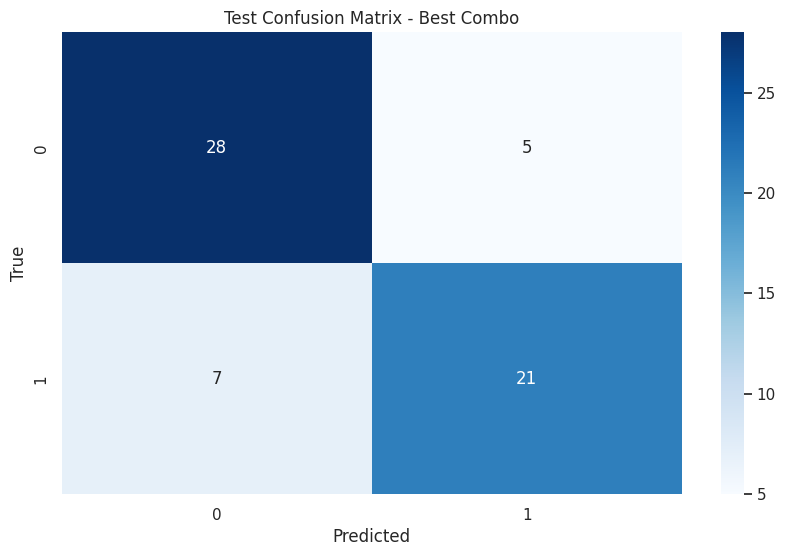

In [ ]:
# Confusion Matrix (for overall best)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix - Best Combo')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

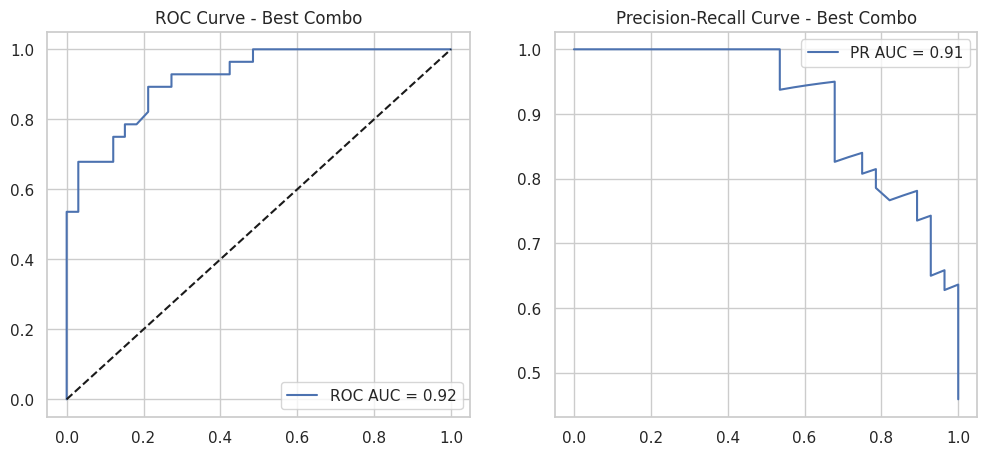

In [ ]:
# ROC and PR Curves (for overall best)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc_val = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_test, y_proba)
pr_auc_val = auc(rec, prec)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_val:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Best Combo')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rec, prec, label=f'PR AUC = {pr_auc_val:.2f}')
plt.title('Precision-Recall Curve - Best Combo')
plt.legend()
plt.show()

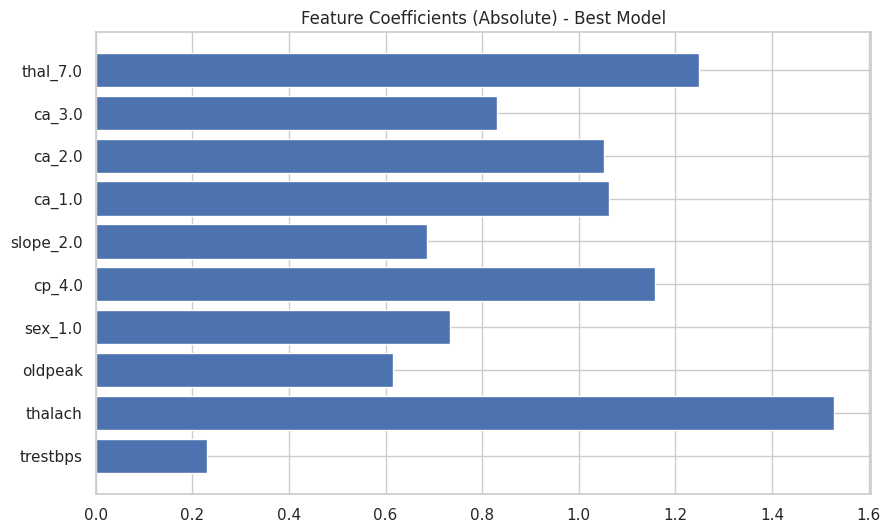

In [ ]:
# Feature Importances (if applicable, for overall best)
# Get selected feature names
num_fe, cat_fe = best_fe_func(X_train)[1:]  # Get num and cat from best FE
all_features = np.concatenate([num_fe, best_preprocessor.named_transformers_['cat'].get_feature_names_out(cat_fe)])
selected_features = all_features[best_fs_indices]

if hasattr(best_model_trained, 'feature_importances_'):
    importances = best_model_trained.feature_importances_
    plt.barh(selected_features, importances)
    plt.title('Feature Importances - Best Model')
    plt.show()
elif isinstance(best_model_trained, LogisticRegression):
    importances = np.abs(best_model_trained.coef_[0])
    plt.barh(selected_features, importances)
    plt.title('Feature Coefficients (Absolute) - Best Model')
    plt.show()

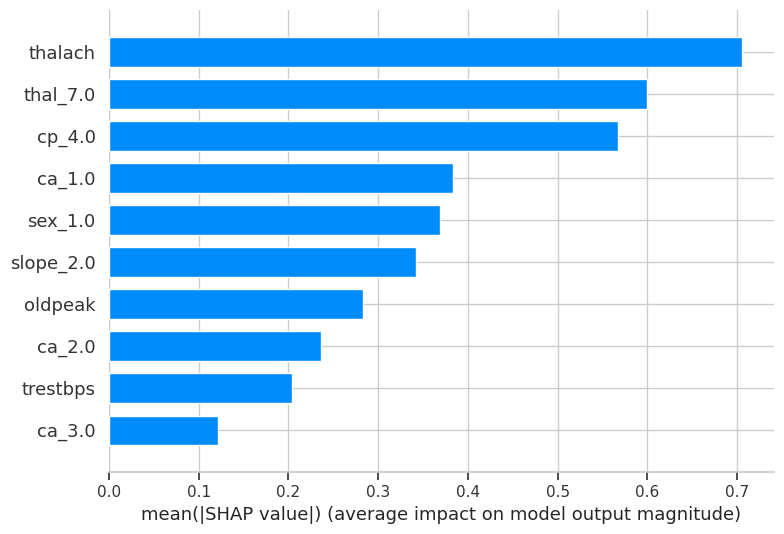

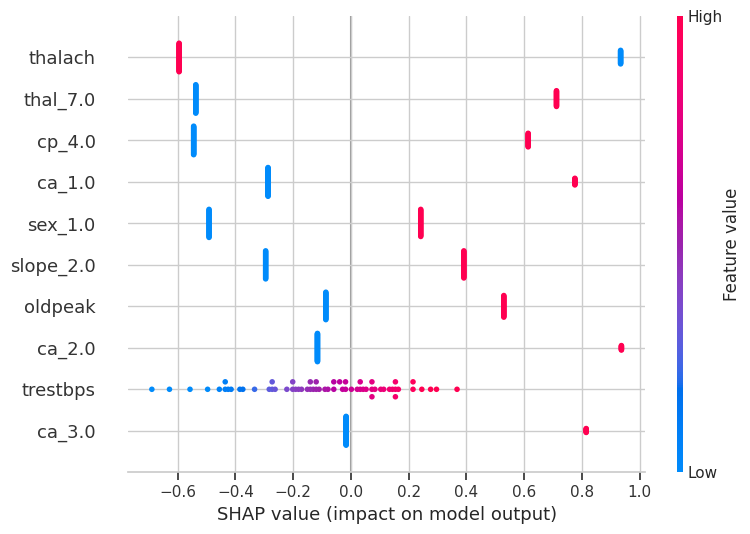

In [ ]:
# SHAP Interpretation for Best Model
import shap.maskers

# Recompute X_train_fs for the masker
X_train_fe, num_fe, cat_fe = best_fe_func(X_train)
X_train_pre = best_preprocessor.transform(X_train_fe)
if hasattr(X_train_pre, 'toarray'):
    X_train_pre = X_train_pre.toarray()
X_train_fs = X_train_pre[:, best_fs_indices]

# Get selected feature names
all_features = np.concatenate([num_fe, best_preprocessor.named_transformers_['cat'].get_feature_names_out(cat_fe)])
selected_features = all_features[best_fs_indices]

masker = shap.maskers.Independent(data=X_train_fs)
explainer = shap.LinearExplainer(best_model_trained, masker, link=shap.links.logit, feature_perturbation="interventional")
shap_values = explainer(X_test_best)

shap.summary_plot(shap_values, X_test_best, feature_names=selected_features, plot_type='bar')
shap.summary_plot(shap_values, X_test_best, feature_names=selected_features)

Average CV AUC without advanced FE: 0.8752
Average CV AUC with advanced FE: 0.8593


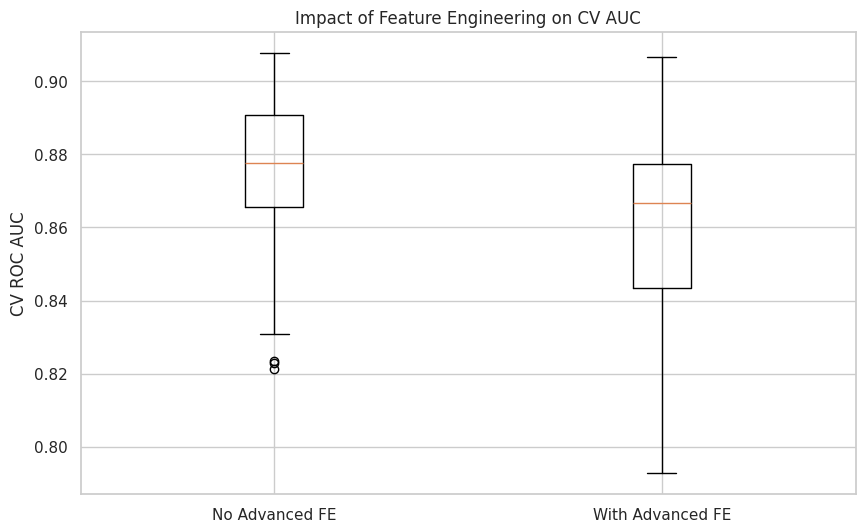

In [ ]:
# Analysis of FE Impact
# Compare CV F1 with and without FE
basic_scores = [res['cv_f1'] for res in results if 'basic' in res['combo']]
enhanced_scores = [res['cv_f1'] for res in results if 'enhanced' in res['combo'] or 'poly_only' in res['combo']]

print(f'Average CV F1 without advanced FE: {np.mean(basic_scores):.4f}')
print(f'Average CV F1 with advanced FE: {np.mean(enhanced_scores):.4f}')

plt.boxplot([basic_scores, enhanced_scores], labels=['No Advanced FE', 'With Advanced FE'])
plt.title('Impact of Feature Engineering on CV F1')
plt.ylabel('CV F1 Score')
plt.show()

In [ ]:
# Predict on a sample with confidence
# Sample input (use mean values or a real test sample; adjust as needed)
sample = X_test.iloc[0:1]  # First test sample for demonstration

sample_fe, _, _ = best_fe_func(sample)
sample_pre = best_preprocessor.transform(sample_fe)
if hasattr(sample_pre, 'toarray'):
    sample_pre = sample_pre.toarray()
sample_best = sample_pre[:, best_fs_indices]

pred = best_model_trained.predict(sample_best)[0]
conf = best_model_trained.predict_proba(sample_best)[0][1] if pred == 1 else best_model_trained.predict_proba(sample_best)[0][0]

print(f'Sample input:\n{sample}')
print(f'Prediction: {pred} ({"Disease" if pred == 1 else "No Disease"})')
print(f'Confidence: {conf:.2%}')

Sample input:
      age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
219  59.0  1.0  4.0     138.0  271.0  0.0      2.0    182.0    0.0      0.0   

     slope   ca  thal  
219    1.0  0.0   3.0  
Prediction: 0 (No Disease)
Confidence: 71.90%


In [ ]:
# Save best model of each type with details
import joblib

dataset = "UCI Heart Disease Cleveland Dataset"

for model_name, info in best_models.items():
    print(f"\nBest Model Type: {model_name.upper()} - {type(info['model']).__name__}")
    combo_parts = info['combo'].split('-')
    model_info = {
        'model_type': model_name,
        'hyperparameters': info['model'].get_params(),
        'dataset': dataset,
        'feature_engineering': combo_parts[0],
        'scaler': combo_parts[1],
        'feature_selection': combo_parts[2],
        'cv_f1': info['cv_f1']
    }
    with open(f'best_{model_name}_model_info.json', 'w') as f:
        json.dump(model_info, f, indent=4)
    print(f"Model info saved to 'best_{model_name}_model_info.json'")
    
    # Save the model and necessary components
    joblib.dump({
        'model': info['model'],
        'preprocessor': info['preprocessor'],
        'fe_func': info['fe_func'],
        'fs_indices': info['fs_indices'],
        'numerical_features': numerical_features,
        'categorical_features': categorical_features
    }, f'best_{model_name}_model_pipeline.pkl')
    
    print(f"Model pipeline saved to 'best_{model_name}_model_pipeline.pkl'")